In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold 
import math
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn import metrics
from scipy import stats as stats
import pickle
%matplotlib inline 

In [ ]:
properties = ['Sol', 'VDss']
loaded_model = pickle.load(open('LGBM_delta_{}.sav'.format(name), 'rb'))

for property in properties:
    dataset = '{}.csv'.format(property)
    pred_dataset = '{}ExternalTestSetFiltered.csv'.format(property)

    # process data
    mols = [Chem.MolFromSmiles(s) for s in dataframe.SMILES]
    fps = [np.array(AllChem.GetMorganFingerprintAsBitVect(m,2)) for m in mols]
    dataframe["Molecule"] = mols
    dataframe["Fingerprint"] = fps

    data = pd.DataFrame(data={'Fingerprint': list(np.array(fps).astype(bool)), 'Y':  dataframe.Y.to_numpy()})

    train_x = dataframe[dataframe.columns[0]]
    dataset = pd.merge(train_x, train_x, how='cross')
    dataset = dataset[['SMILES_y', 'SMILES_x']]

    dataset = dataset.rename(columns={"SMILES_y": "SMILES_x", "SMILES_x": "SMILES_y"})

    pair = pd.merge(data, data, how='cross') # Cross merge the data together
    pair["Fingerprint"] =  pair.Fingerprint_x.combine(pair.Fingerprint_y, np.append) # concatenate ExplicitBitVec objects from RDKIT
    pair["Delta"] = pair.Y_x - pair.Y_y # calculate Delta values
    pair.drop(['Fingerprint_x','Fingerprint_y','Y_x','Y_y'], axis=1, inplace=True) # rid of unnecessary files
    pair["Delta_pred"] = loaded_model.predict(np.vstack(pair.Fingerprint.to_numpy()))  # make predictions
    pair.drop(['Fingerprint'], axis=1, inplace=True)
    pair.to_csv('{}_LGBM_Delta_Preds_Ext.csv'.format(property), index = False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

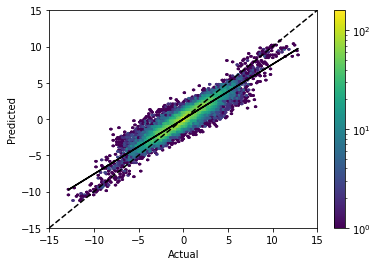

In [ ]:
### Plotting ###
properties = ['Sol', 'VDss']

for property in properties:
    name_2 = '{}-LGBM-Delta-Ext'.format(property)
    fig, ax = plt.subplots()

    ax.hexbin(pair['Delta'], pair['Delta_pred'], gridsize=(100),
                    norm=matplotlib.colors.LogNorm(), mincnt=1)
    fig.colorbar(ax.hexbin(pair['Delta'], pair['Delta_pred'], gridsize=(100),
                    norm=matplotlib.colors.LogNorm(), mincnt=1))

    #line of best fit
    a, b = np.polyfit(pair['Delta'], pair['Delta_pred'], 1)
    plt.plot(pair['Delta'], a*pair['Delta']+b, 'k')


    i = 15
    # X=Y line on the plot
    ax.plot([-i, i], [-i, i], 'k--')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xlim([-i, i])
    ax.set_ylim([-i, i])
    fig.show()

    plt.savefig("{}-HB.png".format(name_2), facecolor='white', dpi = 600)

In [ ]:
### Scoring ###
pearson = stats.pearsonr(pair['Delta'], (pair['Delta_pred']))
MAE = metrics.mean_absolute_error(pair['Delta'],(pair['Delta_pred']))
RMSE = math.sqrt(metrics.mean_squared_error(pair['Delta'], (pair['Delta_pred'])))

scoring = pd.DataFrame({'Metric': ['Pearson\'s r', 'MAE', 'RMSE'], 'Value': [round(pearson[0], 3), round(MAE, 3), round(RMSE, 3)]})
scoring


,Metric,Value
0,Pearson's r,0.929
1,MAE,0.836
2,RMSE,1.121
